In [1]:
import pandas as pd
import numpy as np

# 44. PROJECT-3. Анализ воронки 

## Описание данных

Для проекта мы будем использовать уже знакомый вам датасет — таблицы event и purchase, хранящие данные о действиях пользователей в игре Quiz Freeze.

## Задание

Вот список вопросов, который вы составили после встречи с командой.

### Гипотеза 1
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

### Гипотеза 2
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

### Гипотеза 3
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

## Конкретные шаги (формализованные задачи)

    1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
    2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
    3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Прежде чем перейти непосредственно к решению задач, проведите исследование и предобработку данных, если это необходимо.

Важно! Выполнять задание необходимо на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно).

---

**Функция для создания графика Воронка на основе типа данных Series**

In [2]:
# based on https://support.sisense.com/kb/en/article/funnel-charts-in-python
# Series variable called "df"
import matplotlib.pyplot as plt

# Function: funnel_chart, creates a funnel chart image from a dataframe of steps
# Inputs: (1) dataframe with 2 columns. 
# The first is the "step", and the second is the "val" corresponding to each step. 
# (2) Optional boolean parameter show_n (displays the n size of each step). 
# (3) Optional paramater show_pct which allows the user to show each step of the funnel as 
# a percent of the original n size ('of whole') or a percent or the previous step ('of last step')
# Output: matplotlib image representing a funnel chart
def funnel_chart(df, ifpercent = True, first_max = 0, show_n=True,show_pct='NA', chart_name = 'Funnel Chart'):
  #set up data frame
  if ifpercent:
    if first_max == 0:
      first_max = df.max()
    df = (df/first_max*100).round(2)
  df = df.to_frame()
  df.reset_index(level=0, inplace=True)
  df = df.rename(columns={df.columns[0]: 'step'})
  df = df.rename(columns={df.columns[1]: 'val'})
  #df['val']=df['val'].astype(int)
  my_max=df['val'][0]
  df = df.sort_values('val',ascending=False)
  df = df.reset_index(drop=True)
  df['pct_of_whole']=round((df['val']/my_max)*100,2)#.astype(int)
  pct_change=[100]
  for j in range(1,len(df['val'])):
    pct_change.append(int(round(df['val'][j]/df['val'][j-1]*100)))
  df['pct_change']=pct_change
  df = df.sort_values('val')
  df = df.reset_index(drop=True)
  df['left']=(my_max-df['val'])/2
  df['col']=['indigo','purple','darkviolet','DarkOrchid','MediumOrchid','orchid'] #,'plum','thistle']

  #initialize plot
  fig, ax = plt.subplots()
  for i in range(len(df['step'])):
    ax.barh(0.5*i+0.5, df['val'][i], height=0.3, left=df['left'][i], align='center', color=df['col'][i],alpha = 1.0, label=df['step'][i])
    if(show_n==True):
      ax.annotate(' ' + df['step'][i] + ': ' + str(df['val'][i]),xy=(my_max,0.5*i+0.45),horizontalalignment='left')
    else:
      ax.annotate(' ' + df['step'][i],xy=(my_max,0.5*i+0.45),horizontalalignment='left')
    if(show_pct=='of whole'):
      ax.annotate(str(df['pct_of_whole'][i]) + '%' ,xy=(my_max/2,0.5*i+0.45),horizontalalignment='center',color='white')
    elif(show_pct=='of last step'):
      ax.annotate(str(df['pct_change'][i]) + '%' ,xy=(my_max/2,0.5*i+0.45),horizontalalignment='center',color='white')


  #remove border and align chart
  ax.axis('off')
  fig.subplots_adjust(right=0.8)
  # displaying the title
  plt.title(chart_name)

  return fig

# Use Sisense for Cloud Data Teams to visualize a dataframe or an image by passing data to periscope.output()
# periscope.output(funnel_chart(df,show_n=True,show_pct='of last step'))

---

## 1. Получите данные из файла.
Произведите обзор данных и преобразование данных, если оно необходимо.

In [3]:
purchase = pd.read_csv(r'C:\Users\Yana\Documents\purchase.csv', sep=',')
events = pd.read_csv(r'C:\Users\Yana\Documents\7_4_Events.csv', sep=',')

# purchase = pd.read_csv('purchase.csv') 
# events = pd.read_csv('7_4_Events.csv')

In [4]:
# создать фильтр 2018
cond2018 = (events.start_time>='2018-01-01') & (events.start_time<'2019-01-01') & (events.event_type=='registration')
registered = events[cond2018]  
# список пользователей, зарег. в 2018
lst_reg = registered['user_id'].to_list() 
# отфильтровать пользователей зарег в 2018
events_df = events[events.user_id.isin(lst_reg)].copy() 
purchase_df = purchase[purchase.user_id.isin(lst_reg)].copy() 
# добавить ивент тип покупка
purchase_df['event_type'] = 'purchase' 
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'])
# переименовать айди
events_df = events_df.rename(columns={"id": "event_id"}) 
purchase_df = purchase_df.rename(columns={"id": "purchase_id"})
# изменить тип 
events_df['start_time'] = pd.to_datetime(events_df['start_time'])
events_df['selected_level'] = events_df.selected_level.astype('category')

In [5]:
# переименовать колонку event_datetime на start_time в таблице purchase_df чтобы подготовить к объединению 
purchase_df = purchase_df.rename(columns={"event_datetime": "start_time"})
 # объединить датафреймы
total_events_df = pd.concat([events_df,purchase_df],sort=False)
# изменить тип 
total_events_df['event_type'] = total_events_df.event_type.astype('category')
total_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 51405 to 2778
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  category      
 2   selected_level  8342 non-null   category      
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(4), int64(1)
memory usage: 3.8 MB


---

# 1. Проверка Гипотезы 1
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение.

Влияет ли обучение на скорость прохождения других этапов игры?


**сделаем две группы: пользователи которые**

1. завершили обучение
2. не начинали обучение

## 1.1. Разбивка на группы и проверка

In [6]:
# проверим сколько всего пользователей (от 2018 года) и сколько до какого шага дошли
total_events_df['event_type'].value_counts()

registration       19926
tutorial_start     18050
tutorial_finish    14904
level_choice        8342
pack_choice         5737
purchase            1600
Name: event_type, dtype: int64

In [7]:
# первая группы - пользователи которые завершили туториал хотя бы 1 раз
complete_tutorial_df = total_events_df[total_events_df['event_type'] == 'tutorial_finish'].copy()
set_complete = set(complete_tutorial_df["user_id"].unique())
print(14904/10250 ) #1.4540487804878048
print(len(set_complete)) #10250
complete_tutorial_df.groupby('user_id')['event_type'].count().mean() #1.4540487804878048 OK
complete_tutorial_df.groupby('user_id')['start_time'].count().sum() #14904 OK
complete_tutorial_df.groupby('user_id')['start_time'].count().value_counts() # 22 человека прошли туториал 9 раз?

1.4540487804878048
10250


1    8015
2    1321
3     345
4     178
5     117
6     101
7      97
8      54
9      22
Name: start_time, dtype: int64

In [8]:
# вторая группа - пользователи которые ни разу не прошли туториал
not_complete_tutorial = total_events_df[~total_events_df["user_id"].isin(set_complete)].copy() #9676 unique
not_complete_tutorial['user_id'].nunique() #9676+10250 = 19926 OK registration
set_not_complete = set(not_complete_tutorial["user_id"].unique())
len(set_not_complete) #9676
# not_complete_tutorial.groupby('user_id')['start_time'].count().value_counts()

9676

Какие есть события (этапы)?

Событие          | количество   | количество на пользователя
-----------------|--------------|----------------------------------------
registration     |  19926       | 1
tutorial_start   |  18050       | >1
tutorial_finish  |  14904       | >1
level_choice     |   8342       | 1
pack_choice      |   5737       | 1
purchase         |   1600       | 1

## 1.2. Посчитаем количество пользователей на каждом этапе для обоих групп

In [9]:
# делаем сводную таблицу 
a = total_events_df.pivot_table(
    values='start_time',
    index= ['user_id'],
    columns= 'event_type',
    aggfunc=['min','max'])
# поменять тип на дату для всех колонок 
# уже не надо, сделали раньше
#for column in a.columns:
#    a[column] = pd.to_datetime(a[column])
# вытаскиваем user_id из индекса в колонку
a.reset_index(level=0, inplace=True)
# убираем лишние колонки - вторую дату для событий которые происходят с пользователем только 1 раз
a.drop([('max','level_choice')], axis=1, inplace=True) #level_choice max
a.drop([('max','pack_choice')], axis=1, inplace=True) #pack_choice max
a.drop([('max','registration')], axis=1, inplace=True) #registration max
a.drop([('max','purchase')], axis=1, inplace=True) #purchase max
# переименовать колонки
a.columns = ["_".join((j,k)) for j,k in a.columns]
# упорядочить колонки 
a = a[['user_id_', 'min_registration','min_tutorial_start', 'min_tutorial_finish', 
       'min_level_choice', 'min_pack_choice', 'min_purchase','max_tutorial_start', 'max_tutorial_finish']]
# смотрим что получилось
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19926 entries, 0 to 19925
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id_             19926 non-null  int64         
 1   min_registration     19926 non-null  datetime64[ns]
 2   min_tutorial_start   11858 non-null  datetime64[ns]
 3   min_tutorial_finish  10250 non-null  datetime64[ns]
 4   min_level_choice     8342 non-null   datetime64[ns]
 5   min_pack_choice      5737 non-null   datetime64[ns]
 6   min_purchase         1600 non-null   datetime64[ns]
 7   max_tutorial_start   11858 non-null  datetime64[ns]
 8   max_tutorial_finish  10250 non-null  datetime64[ns]
dtypes: datetime64[ns](8), int64(1)
memory usage: 1.4 MB


In [10]:
# проверка
a['check'] = a['max_tutorial_finish'] - a['min_tutorial_finish']
a['check'].value_counts() # ok 8015 passed tutorial only once

0 days 00:00:00    8015
0 days 04:15:14       3
0 days 02:27:51       3
0 days 02:39:52       2
0 days 09:45:21       2
                   ... 
0 days 00:50:48       1
0 days 07:23:28       1
0 days 07:24:08       1
0 days 00:47:37       1
0 days 16:22:48       1
Name: check, Length: 2193, dtype: int64

### Построим 3 графика воронки:
1. Для всех пользователей 
2. Для пользователей которые прошли туториал
3. Для пользователей которые НЕ прошли туториал

In [11]:
# data for funnel chart: total
total = a.iloc[:,1:7].count()

complete_df_pivot = a[a["user_id_"].isin(set_complete)].copy()
# data for funnel chart: users who completed tutorial
complete = complete_df_pivot.iloc[:,1:7].count()

not_complete_df_pivot = a[a["user_id_"].isin(set_not_complete)].copy()
# data for funnel chart: users who did NOT complete tutorial
not_complete = not_complete_df_pivot.iloc[:,1:7].count()

ok


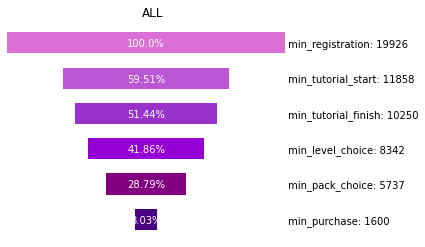

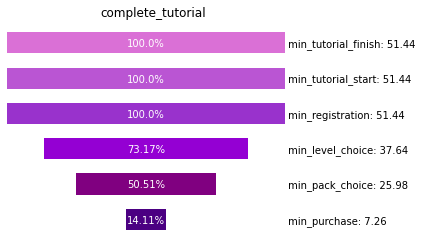

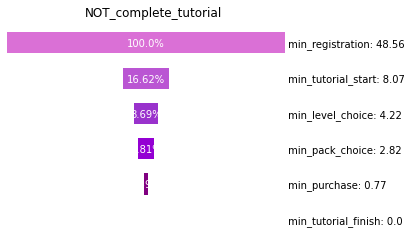

In [12]:
funnel_chart(total, False, 19926, True, 'of whole', 'ALL')
funnel_chart(complete, True, 19926, True, 'of whole', 'complete_tutorial')
funnel_chart(not_complete, True, 19926, True, 'of whole', 'NOT_complete_tutorial')
print('ok')

In [13]:
# соберем все данные в таблицу
total = total.to_frame()
total[1] = complete
total[2] = not_complete
total.columns = ['total','complete', 'not_complete']
total.index = ['registration','tut_start', 'tut_finish', 'lvl_choice', 'pack_choice', 'purchase']
total

,total,complete,not_complete
registration,19926,10250,9676
tut_start,11858,10250,1608
tut_finish,10250,10250,0
lvl_choice,8342,7501,841
pack_choice,5737,5176,561
purchase,1600,1447,153


### Промежуточные выводы: анализ воронки
1. всего в 2018 году зарегистрировалось 19926 пользователей, из них 8% совершили покупку
2. из всех пользователей 51% завершили туториал, из них 14% совершили покупку - то есть они совершили 90% всех покупок
3. из всех пользователей 49% не завершили туториал, из них всего 2% совершили покупку
4. 4% пользователей начали но не завершили туториал

## 1.3. Теперь считаем timedelta

In [14]:
# function to substract previous column from choosen column
def substract_prev_column(df,col_nr):
    x = df.iloc[:,(col_nr)] - df.iloc[:,(col_nr-1)]
    x = x.to_frame()
    return x

In [15]:
# function to make timedelta df
def calc_timedelta(df):
    timedelta_df = df['user_id_'].to_frame()
    for i in range(2,len(list(df))-2):
        timedelta_df[i] = df.iloc[:,(i)] - df.iloc[:,1] #substract_prev_column(df,i)
    timedelta_df.columns = ['user_id_', 'registration-tutorial_start','registration-tutorial_finish',
                            'registration-level_choice', 'registration-pack_choice', 'registration-purchase']
    #timedelta_df.columns = ['user_id_', 'reg_tut_st_min', 'tut_st_min_fin_max', 'tut_fin_max_lvl', 'lvl_pack', 'pack_pur']
    return timedelta_df

In [16]:
# упорядочить колонки 
complete_df_pivot = complete_df_pivot[['user_id_', 'min_registration','min_tutorial_start', 'min_tutorial_finish', 
       'min_level_choice', 'min_pack_choice', 'min_purchase','max_tutorial_start','max_tutorial_finish' ]]
# calculate timedelta
complete_timedelta = calc_timedelta(complete_df_pivot)
complete_timedelta.info() # ok

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10250 entries, 1 to 19924
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   user_id_                      10250 non-null  int64          
 1   registration-tutorial_start   10250 non-null  timedelta64[ns]
 2   registration-tutorial_finish  10250 non-null  timedelta64[ns]
 3   registration-level_choice     7501 non-null   timedelta64[ns]
 4   registration-pack_choice      5176 non-null   timedelta64[ns]
 5   registration-purchase         1447 non-null   timedelta64[ns]
dtypes: int64(1), timedelta64[ns](5)
memory usage: 560.5 KB


In [17]:
# упорядочить колонки 
not_complete_df_pivot = not_complete_df_pivot[['user_id_', 'min_registration','min_tutorial_start', 
                                               'min_tutorial_finish', 'min_level_choice', 
                                               'min_pack_choice', 'min_purchase','max_tutorial_start',
                                               'max_tutorial_finish' ]]
# calculate timedelta
not_complete_timedelta = calc_timedelta(not_complete_df_pivot)
#not_complete_timedelta.info() # ok

In [18]:
# соберем все данные в таблицу
result = complete_timedelta.iloc[:,1:].mean().to_frame()
result[1] = (result[0] / np.timedelta64(1, 'h')).round(2)
result[2] = not_complete_timedelta.iloc[:,1:].mean().to_frame()
result[3] = (result[2] / np.timedelta64(1, 'h')).round(2)
result.columns = ['complete_timedelta_mean', 'hours_1', 'not_complete_timedelta_mean' , 'hours_2']
result['who_is_faster'] = np.where(result['hours_1']>result['hours_2'], 'who_did_NOT_complete', 'who_completed')
result.index.name = 'steps'
result.reset_index(level=0, inplace=True)

**Построим столбчатую диаграмму для двух групп**

,steps,complete_timedelta_mean,hours_1,not_complete_timedelta_mean,hours_2,who_is_faster
0,registration-tutorial_start,0 days 04:31:04.938146341,4.52,0 days 05:25:02.892412935,5.42,who_completed
1,registration-tutorial_finish,0 days 04:43:18.761268292,4.72,NaT,NaN,who_completed
2,registration-level_choice,0 days 07:05:36.854819357,7.09,0 days 07:52:17.178359096,7.87,who_completed
3,registration-pack_choice,0 days 07:10:35.660162287,7.18,0 days 07:56:46.937611408,7.95,who_completed
4,registration-purchase,4 days 00:30:03.247408431,96.50,4 days 06:03:32.111111111,102.06,who_completed


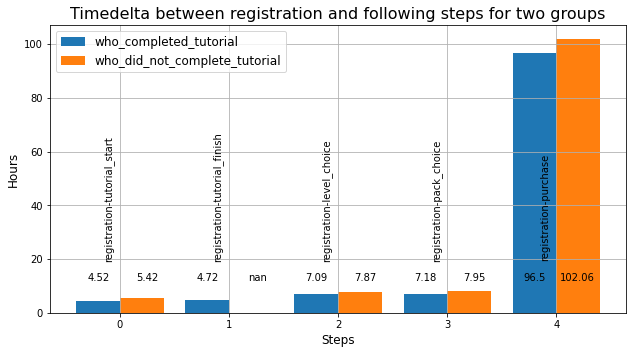

In [19]:
# create data
x = np.arange(5)
y1 = result['hours_1']
y2 = result['hours_2']
width = 0.40
#визуализация главного графика
fig = plt.figure(figsize=(8, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
# plot data in grouped manner of bar type
main_axes.bar(x-0.2, y1, width)
main_axes.bar(x+0.2, y2, width)
#установка параметров отображения
main_axes.set_title('Timedelta between registration and following steps for two groups', fontsize=16)
main_axes.set_xlabel('Steps', fontsize=12)
main_axes.set_ylabel('Hours', fontsize=12)
#main_axes.set_yticks(range(0, 100000, 10000))
#main_axes.xaxis.set_tick_params(rotation=30)
main_axes.grid()
#main_axes.set_yscale('log')
main_axes.legend(['who_completed_tutorial', 'who_did_not_complete_tutorial'],fontsize=12)
#добавить аннотацию
for i in range(len(result['hours_1'])):
    main_axes.annotate(str(result['hours_1'][i]),xy=[(i-0.3),12],horizontalalignment='left')
    main_axes.annotate(str(result['hours_2'][i]),xy=[(i+0.35),12],horizontalalignment='right')
    main_axes.annotate(str(result['steps'][i]),xy=[(i-0.1),(20)],horizontalalignment='center',rotation=90)
# показать таблицу с данными
display(result)

### Промежуточные выводы: влияет ли обучение на скорость прохождения других этапов игры?

**Результаты:**

тем, кто не прошел туториал в целом требуется больше времени чтобы перейти от одного шага к следующему

## 1.4. Проверка Гипотезы 1
#### Гипотеза:
"По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Влияет ли обучение на скорость прохождения других этапов игры?"

#### Выводы:
Да, в поведении групп есть разница. Те, кто прошел обучение (а это половина от всех пользователей):
1. с большей вероятностью совершат покупку (14,11% от группы прошедших против 1,56% от группы не прошедших обучение),
2. быстрее совершат покупку (в среднем от регистрации до покупки проходит 96,5 часов против 102,0).


---

# 2. Проверка Гипотезы 2
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

## 2.1. Разделим на группы
По количеству завершенных туториалов - получится 9 групп. 


In [20]:
complete_tutorial_df.groupby('user_id')['start_time'].count().value_counts() 
# 22 человека прошли туториал 9 раз

1    8015
2    1321
3     345
4     178
5     117
6     101
7      97
8      54
9      22
Name: start_time, dtype: int64

In [21]:
# сделаем таблицу в которой посчитаем количество завершенных туториалов на пользователя
f = complete_tutorial_df.groupby('user_id')['start_time'].count()
f = f.to_frame()
f = f.reset_index()
f.columns = ['user_id_', 'tutorial_counts']

## 2.2. Считаем сколько человек продвинулось на следующие шаги после завершения туториала в каждой из 9 групп


In [22]:
# Уберем лишние колонки
complete_timedelta = complete_timedelta.drop('registration-tutorial_start',1)

C:\Users\Yana\AppData\Local\Temp/ipykernel_5836/1573102315.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  complete_timedelta = complete_timedelta.drop('registration-tutorial_start',1)


In [23]:
# добавим колонку с количеством пройденных туториалов
complete_timedelta_tut_fin = pd.merge(complete_timedelta, f, how='inner', on='user_id_')

In [24]:
def groupcounter(df,column):
    a = df.groupby('tutorial_counts')[column].count()
    return a

In [25]:
# создадим таблицу с количеством человек на каждом шаге для 9 групп
#ind_lst = [1,2,3,4,5,6,7,8,9]
hyp2_count = pd.DataFrame({
        #'steps': ind_lst,
        'registration-tutorial_finish': groupcounter(complete_timedelta_tut_fin, 'registration-tutorial_finish'),
        'registration-level_choice': groupcounter(complete_timedelta_tut_fin, 'registration-level_choice'),
        'registration-pack_choice': groupcounter(complete_timedelta_tut_fin, 'registration-pack_choice'),
        'registration-purchase': groupcounter(complete_timedelta_tut_fin, 'registration-purchase'),
                   })

In [26]:
# пересчитаем количество в проценты
hyp2_percent = hyp2_count.transpose()

for i in range(1,10):
    colmax = hyp2_percent[i].max()
    hyp2_percent[i] = round((hyp2_percent[i]/colmax*100),2)

Построим график

tutorial_counts,1,2,3,4,5,6,7,8,9,average
registration-level_choice,73.85,70.63,68.12,67.98,74.36,73.27,78.35,74.07,72.73,72.60
registration-pack_choice,51.18,48.75,44.06,39.33,52.99,48.51,57.73,51.85,59.09,50.39
registration-purchase,14.26,13.78,12.75,10.67,16.24,14.85,15.46,11.11,18.18,14.14


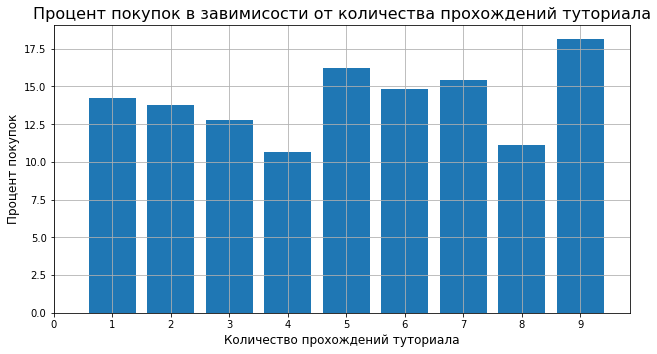

In [27]:
# create data
x = hyp2_percent.transpose().index[:]
y1 = hyp2_percent.transpose()['registration-purchase'][:]
#визуализация главного графика
fig = plt.figure(figsize=(8, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
# plot data in grouped manner of bar type
main_axes.bar(x, y1)
#установка параметров отображения
main_axes.set_xticks(np.arange(len(x)+1))
main_axes.set_title('Процент покупок в завимисости от количества прохождений туториала', fontsize=16)
main_axes.set_xlabel('Количество прохождений туториала', fontsize=12)
main_axes.set_ylabel('Процент покупок', fontsize=12)
#main_axes.set_yticks(range(0, 100000, 10000))
#main_axes.xaxis.set_tick_params(rotation=30)
main_axes.grid()
#main_axes.set_yscale('log')
#main_axes.legend(['who_completed_tutorial', 'who_did_not_complete_tutorial'],fontsize=12)
# покажем таблицу с результатами
hyp2_percent['average'] = hyp2_percent.mean(axis=1).round(2)
hyp2_percent.iloc[1: , :]

### Промежуточные выводы:
Процент покупателей в среднем равен проценту покупателей в группе 1 (те, кто прошел туториал 1 раз): 14%

Самый лучший результат 18% - у группы 9

Самый худщий результат 11% - у групп 4 и 8

Тренд не наблюдается

## 2.3. Считаем таймдельту для 9 групп

In [28]:
def groupmean(df,column):
    a = df.groupby('tutorial_counts')[column].mean() / np.timedelta64(1, 'h')
    return a

In [29]:
#ind_lst = [1,2,3,4,5,6,7,8,9]
hyp2_mean = pd.DataFrame({
        #'steps': ind_lst,
        'registration-tutorial_finish': groupmean(complete_timedelta_tut_fin, 'registration-tutorial_finish'),
        'registration-level_choice': groupmean(complete_timedelta_tut_fin, 'registration-level_choice'),
        'registration-pack_choice': groupmean(complete_timedelta_tut_fin, 'registration-pack_choice'),
        'registration-purchase': groupmean(complete_timedelta_tut_fin, 'registration-purchase'),
                   })
hyp2_mean = hyp2_mean.transpose().round(2)

Построим графики

tutorial_counts,1,2,3,4,5,6,7,8,9,average
registration-tutorial_finish,5.36,3.04,1.97,1.60,1.40,1.11,0.99,0.81,0.76,1.89
registration-level_choice,7.71,5.42,4.48,3.82,3.91,3.45,3.34,3.13,2.86,4.24
registration-pack_choice,7.78,5.50,4.52,3.51,4.20,3.59,3.36,3.42,2.94,4.31
registration-purchase,96.60,95.91,96.37,89.38,102.89,85.56,107.90,78.07,125.08,97.53


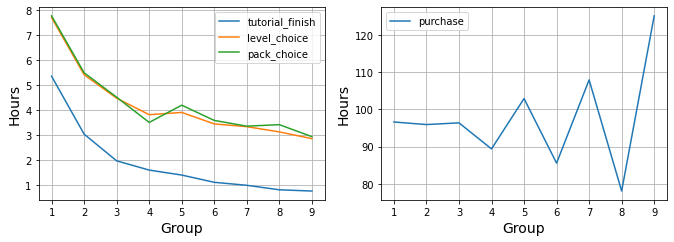

In [30]:
# plot lines
fig = plt.figure(figsize=(10, 4))

x = hyp2_mean.transpose().index[:]
 
plt.subplot(1,2, 1) 
# plot lines
y = hyp2_mean.transpose()['registration-tutorial_finish'][:]
plt.plot(x, y, label = "tutorial_finish")
y = hyp2_mean.transpose()['registration-level_choice'][:]
plt.plot(x, y, label = "level_choice")
y = hyp2_mean.transpose()['registration-pack_choice'][:]
plt.plot(x, y, label = "pack_choice")
plt.legend()
plt.grid()
plt.xlabel('Group', fontsize=14)
plt.ylabel('Hours', fontsize=14)

plt.subplot(1,2, 2) 
y = hyp2_mean.transpose()['registration-purchase'][:]
plt.plot(x, y, label = "purchase")

fig.tight_layout(pad=3.0)

plt.legend()
plt.grid()
plt.xlabel('Group', fontsize=14)
plt.ylabel('Hours', fontsize=14)

# покажем таблицу
hyp2_mean['average'] = hyp2_mean.mean(axis=1).round(2)
hyp2_mean


### Промежуточные выводы:
Время от регистрации до покупки не сильно меняется от группы 1 до группы 3, но потом начинает меняться скачкообразно с увеличением амплитуды. Среднее значение на 1 час больше времения для группы 1. Для четных групп (те, кто прошел туториал четное количество раз) время от регистрации до покупки уменьшается. Для нечетных групп время до покупки увеличивается.

Интересно что время от регистрации до событий первого прохождения туториала (min_tutorial_finish), выбора уровня (level_choice) и выбора бесплатных вопросов (pack_choice) плавно уменьшается от группы 1 до группы 9. Как можно объяснить подобное поведение? Еще более странно то, что время от регистрации до покупки (purchase) меняется скачкообразно.

## 2.4. Проверка Гипотезы 2
**Гипотеза**

Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

**Выводы**

    1. Повторное прохождение туторила не увеличивает процент совершенных покупок. 
    2. Время от регистрации до покупки изменяется скачкообразно, такое поведение вряд ли нормально, имеет смысл проверить данные. 

Но если все верно, то при таких результатах не стоит продвигать множественное прохождение туториала.

---

# 3. Проверка Гипотезы 3
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

## 3.1. Считаем таймдельту
надо посчитать таймдельту между выбором сложности обучения (level_choice) и первым стартом обучения (min_tutorial_start), для тех, кто сначала выбрал сложность а потом начал обучение, эта таймдельта будет отрицательной

In [31]:
a['check'] = a['min_level_choice'] - a['min_tutorial_start']

In [32]:
# установим ноль
ziro = pd.Timedelta(0)
# список тех пользователей, для кого таймдельта отрицательна
mask = a['check'] < ziro
len(a[mask]['user_id_']) 

0

In [33]:
# проверка 
a['check2'] = a['min_level_choice'] - a['max_tutorial_start']
# список тех, кто прошел туториал повторно после выбора уровня
mask = a['check2'] < ziro
len(a[mask]['user_id_']) 

1386

In [34]:
# сколько их них совершили покупку?
set_repeaters = set(a[mask]['user_id_'])
repeaters_df = a[a['user_id_'].isin(set_repeaters)].copy()
print("из повторивших туториал после выбора уровня:")
print(str(round((repeaters_df['min_pack_choice'].count()/1386*100),2))+'% из них выбрали бесплатные вопросы')
print(str(round((repeaters_df['min_purchase'].count()/1386*100),2)) + '% из них совершили покупку')

из повторивших туториал после выбора уровня:
66.59% из них выбрали бесплатные вопросы
19.12% из них совершили покупку


## 3. Проверка Гипотезы 3
**Гипотеза:**

Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

**Выводы:**

Нет, не будет. 

**Дополнительная информация**

7% пользователей прошли обучение повторно после выбора уровня.